# Miniproject 3: Poem Generation

### Download Data

In [5]:
import requests

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


### Importing packages \& Preprocessing

In [3]:
#HW6 Code
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation

**Function for data preprocessing** \
We will use the parse_observations function from HW6 to process and tokenize the text data.


In [6]:
####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []

        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1

            # Add the encoded word.
            obs_elem.append(obs_map[word])

        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

In [7]:
# Given the syllable_dictionary file, maps each word to its syllable count, in which
# some have more than 1, as outlined in the given file.

def syllable_dictionary():
    with open('syllable_dict.txt', 'r') as file:
        shakespeare_text = file.read()
    lines = shakespeare_text.splitlines()

    syllable_dictionary = {}
    for line in lines:
        line = line.split()
        word = re.sub(r'[^\w]', '', line[0]).lower()

        # store end of line syllables and normal syllables
        syllable_count = [-1, []]
        for elem in line[1:]:
            if ('E' in elem):
                syllable_count[0] = int(elem[1:])
            else:
                syllable_count[1].append(int(elem))
        syllable_dictionary[word] = syllable_count

    return syllable_dictionary

syllable_dictionary = syllable_dictionary()

# Implementing Models

## HMM Code

In [8]:
from posixpath import join
from ast import Num

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.

        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        #Base Case
        for a in range(self.L):
            probs[1][a] = self.A_start[a] * self.O[a][x[0]]
            seqs[1][a] = str(a)

        for i in range(2, M + 1):
            for j in range(self.L):
                max_prob = 0
                max_seq = ''
                for k in range(self.L):
                    p = probs[i - 1][k] * self.A[k][j] * self.O[j][x[i-1]]
                    if p > max_prob:
                        max_prob = p
                        max_seq = seqs[i - 1][k] + str(j)
                probs[i][j] = max_prob
                seqs[i][j] = max_seq

        max_prob = 0
        max_seq = ''
        for i in range(self.L):
            if probs[M][i] > max_prob:
                max_prob = probs[M][i]
                max_seq = seqs[M][i]
        return max_seq

    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for a in range(self.L):
            alphas[1][a] = self.A_start[a] * self.O[a][x[0]]

        for i in range(2, M + 1):
          for j in range(self.L):
            for k in range(self.L):
              alphas[i][j] += alphas[i-1][k] * self.A[k][j] * self.O[j][x[i - 1]]
          if normalize:
            total = sum(alphas[i])
            alphas[i] = [a / total for a in alphas[i]]
        return alphas

    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for b in range(self.L):
          betas[M][b] = 1.0

        for i in range(M - 1, 0, -1):
          for j in range(self.L):
            for k in range(self.L):
              betas[i][j] += betas[i + 1][k] * self.A[j][k] * self.O[k][x[i]]
          if normalize:
            total = sum(betas[i])
            betas[i] = [b / total for b in betas[i]]
        return betas

    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''
        # xounting
        # Calculate each element of A using the M-step formulas.
        N = len(X)
        for a in range(self.L):
          for b in range(self.L):
            num = 0
            denom = 0
            for i in range(N):
              M = len(Y[i])
              for j in range(1, M):
                if Y[i][j - 1] == a:
                  denom += 1
                  if Y[i][j] == b:
                    num += 1
            self.A[a][b] = num / denom

        # Calculate each element of O using the M-step formulas.
        for a in range(self.L):
          for w in range(self.D):
            num = 0
            denom = 0
            for i in range(N):
              M = len(Y[i])
              for j in range(M):
                if Y[i][j] == a:
                  denom += 1
                  if X[i][j] == w:
                      num += 1
            self.O[a][w] = num / denom

    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
            hehe (for locating)
        '''

        for n in range(N_iters):
            print('iter = {}'.format(n))
            A_num = [[0. for _ in range(self.L)] for _ in range(self.L)]
            A_denom = [0. for _ in range(self.L)]
            O_num = [[0. for _ in range(self.D)] for _ in range(self.L)]
            O_denom = [0. for _ in range(self.L)]

            for x in X:
                M = len(x)
                alphas = self.forward(x, True)
                betas = self.backward(x, True)

                for i in range(1, M + 1):
                    temp_O = [alphas[i][j] * betas[i][j] for j in range(self.L)]
                    total = sum(temp_O)
                    temp_O = [t / total for t in temp_O]

                    for j in range(self.L):
                        if i < M:
                            A_denom[j] += temp_O[j]
                        O_num[j][x[i - 1]] += temp_O[j]
                        O_denom[j] += temp_O[j]

                for i in range(1, M):
                    temp_A = [[0. for _ in range(self.L)] for _ in range(self.L)]
                    for j in range(self.L):
                        for k in range(self.L):
                            temp_A[j][k] = alphas[i][j] * self.A[j][k] * self.O[k][x[i]] * betas[i + 1][k]
                    total = 0
                    for t in temp_A:
                        total += sum(t)
                    for j in range(self.L):
                        for k in range(self.L):
                            A_num[j][k] += temp_A[j][k] / total

            for i in range(self.L):
                for j in range(self.L):
                    self.A[i][j] = A_num[i][j] / A_denom[i]
                for w in range(self.D):
                    self.O[i][w] = O_num[i][w] / O_denom[i]

    def generate_emission(self, M, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        #starting state chosen uniformly at random
        state = rng.integers(0, self.L)
        states.append(state)
        emission.append(rng.choice(range(self.D), p=self.O[state]))

        for i in range(1, M):
          state = rng.choice(range(self.L), p=self.A[state])
          emission.append(rng.choice(range(self.D), p=self.O[state]))
          states.append(state)

        return emission, states


    def generate_syllable_emission(self, syllable_dictionary, obs_map, seed=None):
        """
        Generates 14 lines, 10 syllables for each line
        """
        num_lines = 14
        syllables_per_line = 10

        # invert obs_map
        int_to_word = dict((v, k) for k, v in obs_map.items())

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        #starting state chosen uniformly at random
        state = rng.integers(0, self.L)
        states.append(state)

        line = []
        line.append(int_to_word[rng.choice(range(self.D), p=self.O[state])])

        for i in range(num_lines):
            syllables_min = syllables_max = 0
            if (i == 0):
                syllable_pos = syllable_dictionary[line[0]][1]
                syllables_min += min(syllable_pos)
                syllables_max += max(syllable_pos)

            while (True):
                temp_state = rng.choice(range(self.L), p=self.A[state])
                temp_emission = int_to_word[rng.choice(range(self.D), p=self.O[temp_state])]
                if (temp_emission.isdigit()):
                    continue

                syllable_pos = syllable_dictionary[temp_emission]
                if (syllable_pos[0] == -1):
                    # can end line
                    if (syllables_min + min(syllable_pos[1]) <= syllables_per_line and syllables_max + max(syllable_pos[1]) >= syllables_per_line):
                        state = temp_state
                        states.append(state)
                        line.append(temp_emission)
                        break

                    # check if have to resample
                    if (syllables_min + min(syllable_pos[1]) > syllables_per_line):
                        continue

                    syllables_min += min(syllable_pos[1])
                    syllables_max += max(syllable_pos[1])
                    state = temp_state
                    states.append(state)
                    line.append(temp_emission)
                else:
                    # can end line
                    if (syllables_min + syllable_pos[0] <= syllables_per_line and syllables_max + syllable_pos[0] >= syllables_per_line):
                        state = temp_state
                        states.append(state)
                        line.append(temp_emission)
                        break

                    # check if have to resample
                    if (syllables_min + syllable_pos[0] > syllables_per_line):
                        continue

                    syllables_min += min(syllable_pos[1])
                    syllables_max += max(syllable_pos[1])
                    state = temp_state
                    states.append(state)
                    line.append(temp_emission)
            emission.append(line)
            line = []
        return emission, states


    def generate_rhyme_emission(self, rhyme_dict, syllable_dictionary, obs_map, seed=None):
        rhyme_scheme = [[0, 2], [1, 3], [4, 6], [5, 7], [8, 10], [9, 11], [12, 13]]

        num_lines = 14
        syllables_per_line = 10

        # invert obs_map
        obs_map_r = obs_map_reverser(obs_map)

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        states = [[] for _ in range(num_lines)]
        emission = [[] for _ in range(num_lines)]

        self.O = np.array(self.O)
        self.A = np.array(self.A)

        # initialize end of each line
        for i, j in rhyme_scheme:
            word1 = rng.choice(list(rhyme_dict.keys()))
            word2 = rng.choice(rhyme_dict[word1])

            state1 = rng.choice(range(self.L), p=self.O[:, word1] / np.sum(self.O[:, word1]))
            state2 = rng.choice(range(self.L), p=self.O[:, word1] / np.sum(self.O[:, word1]))

            states[i].append(state1)
            states[j].append(state2)

            emission[i].append(obs_map_r[word1])
            emission[j].append(obs_map_r[word2])

        for i in range(num_lines):
            syllable_pos = syllable_dictionary[emission[i][0]][1]
            syllables_min = min(syllable_pos)
            syllables_max = max(syllable_pos)

            j = 0
            while (True):
                temp_state = rng.choice(range(self.L), p=self.A[:, states[i][j]] / np.sum(self.A[:, states[i][j]]))
                temp_emission = obs_map_r[rng.choice(range(self.D), p=self.O[temp_state])]
                if (temp_emission.isdigit()):
                    continue

                syllable_pos = syllable_dictionary[temp_emission]
                if (syllable_pos[0] == -1):
                    # can end line
                    if (syllables_min + min(syllable_pos[1]) <= syllables_per_line and syllables_max + max(syllable_pos[1]) >= syllables_per_line):
                        states[i].append(temp_state)
                        emission[i].append(temp_emission)
                        break

                    # check if have to resample
                    if (syllables_min + min(syllable_pos[1]) > syllables_per_line):
                        continue

                    syllables_min += min(syllable_pos[1])
                    syllables_max += max(syllable_pos[1])
                    states[i].append(temp_state)
                    emission[i].append(temp_emission)
                else:
                    # can end line
                    if (syllables_min + syllable_pos[0] <= syllables_per_line and syllables_max + syllable_pos[0] >= syllables_per_line):
                        states[i].append(temp_state)
                        emission[i].append(temp_emission)
                        break

                    # check if have to resample
                    if (syllables_min + syllable_pos[0] > syllables_per_line):
                        continue

                    syllables_min += min(syllable_pos[1])
                    syllables_max += max(syllable_pos[1])
                    states[i].append(temp_state)
                    emission[i].append(temp_emission)

                j += 1
            emission[i] = reversed(emission[i])

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)

    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters, seed=None):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.

        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''
    # Initialize random number generator
    rng = np.random.default_rng(seed=seed)

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

In [9]:
#same as HW6
def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize()

Below is our first try of naive poem generation

In [ ]:
with open('shakespeare.txt', 'r') as file:
    shakespeare_text = file.read()
obs, obs_map = parse_observations(shakespeare_text)

n_states = 16
N_iters = 100
HMM = unsupervised_HMM(obs, n_states, N_iters)

iter = 0
iter = 1
iter = 2
iter = 3
iter = 4
iter = 5
iter = 6
iter = 7
iter = 8
iter = 9
iter = 10
iter = 11
iter = 12
iter = 13
iter = 14
iter = 15
iter = 16
iter = 17
iter = 18
iter = 19
iter = 20
iter = 21
iter = 22
iter = 23
iter = 24
iter = 25
iter = 26
iter = 27
iter = 28
iter = 29
iter = 30
iter = 31
iter = 32
iter = 33
iter = 34
iter = 35
iter = 36
iter = 37
iter = 38
iter = 39
iter = 40
iter = 41
iter = 42
iter = 43
iter = 44
iter = 45
iter = 46
iter = 47
iter = 48
iter = 49
iter = 50
iter = 51
iter = 52
iter = 53
iter = 54
iter = 55
iter = 56
iter = 57
iter = 58
iter = 59
iter = 60
iter = 61
iter = 62
iter = 63
iter = 64
iter = 65
iter = 66
iter = 67
iter = 68
iter = 69
iter = 70
iter = 71
iter = 72
iter = 73
iter = 74
iter = 75
iter = 76
iter = 77
iter = 78
iter = 79
iter = 80
iter = 81
iter = 82
iter = 83
iter = 84
iter = 85
iter = 86
iter = 87
iter = 88
iter = 89
iter = 90
iter = 91
iter = 92
iter = 93
iter = 94
iter = 95
iter = 96
iter = 97
iter = 98
iter = 99


In [ ]:
for i in range(14):
  print(sample_sentence(HMM, obs_map, 10))

Write but his deep a doth proved i me suffring
Long loves that keep of men pays truly of my
And brave giving thou cannot seem i life in boy
Like my belong or excel wrought my thou full in
And you so your concord of and are eat in
This but even thy sin five define times lips since
And you luck doth all in not of star prophecies
Again thy love not denote with for our base were
Then these living flatterer say say more almost wrinkles men
Razed you in my love to more in faults upon
Habitation in glass virtue this thousand thy many me of
Doth fury lies height is my rhetoric of confounding thou
So but maketh bare oer i fears every thy truth
Anger yet well two o murdrous thee thy april but


## RNN Code

We used code and the model definition from this example given by keras:  https://keras.io/examples/generative/lstm_character_level_text_generation/

In [10]:
import keras
from keras import layers

import numpy as np
import random
import re
import string

In [ ]:
with open('shakespeare.txt', 'r') as file:
    shakespeare = file.read().lower().strip()

# think about moving the space
corpus = shakespeare
# corpus = shakespeare.replace("\n", "") # Remove newlines chars
text = re.sub(r'[0-9]', '', corpus) # this removes sonnet headers
print("Corpus length:", len(text))

chars = sorted(list(set(text))) # includes punctuation
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# creating semi-redundant sequences of length 40
seq_len = 40
step_size = 5 # change?
sequences = []
next_chars = []
for i in range(0, len(text) - seq_len, step_size):
    sequences.append(text[i : i + seq_len])
    next_chars.append(text[i + seq_len])
print("Number of sequences:", len(sequences))

# one-hot encoding:
# Iterates over each character in a sequence.
x = np.zeros((len(sequences), seq_len, len(chars)), dtype="bool")
y = np.zeros((len(sequences), len(chars)), dtype="bool")
for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        x[i][t][char_indices[char]] = 1
    y[i][char_indices[next_chars[i]]] = 1

Corpus length: 97656
Total chars: 38
Number of sequences: 19524


Train a character-based LSTM model. A single layer of 100-200 LSTM units should be sufficient. You should also have a standard fully-connected output layer with a softmax nonlinearity. \


*   Train a character-based LSTM model. A single layer of 100-200 LSTM units should be sufficient. You should also have a standard fully-connected output layer with a softmax nonlinearity.
*   Train your model to minimize categorical cross-entropy. Make sure that you train for a sufficient number of epochs so that your loss converges. You dont necessarily need to keep track of overfitting/keep a validation set.
Your training data should consist of sequences of fixed length (40 characters
is a good number for this task) drawn from the sonnet corpus. The densest way to do this is to take all possible subsequences of 40 consecutive characters from the dataset. To speed up training, using semi-redundant sequences (i.e. picking only sequences starting every n-th character) works just as well.
*   To generate poems, draw softmax samples from your trained model. It may be interesting to play around with the temperature parameter, an RNN/LSTM hyperparameter which controls the variance of your sampled text. This is done by dividing the logits generated by the dense layers of the RNN/LSTM by the temperature before applying the softmax when sampling. \
https://github.com/keras-team/keras/issues/3092







In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(seq_len, len(chars))),
        layers.LSTM(200),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

epochs = 40
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - seq_len - 1)
    for temperature in [1.5, 0.75, 0.25]:
        print("Temperature:", temperature)

        generated = ""
        sentence = "shall i compare thee to a summer\'s day?\n"
        print(len(sentence))
        print('Given sequence: "' + sentence + '"')

        lines = sentence.count("\n")
        # generate characters until 14 lines are generated (sonnets have 14 lines)
        # dont generate too many characters
        while (lines <= 13 and len(generated) <= 450):
            x_pred = np.zeros((1, seq_len, len(chars)), dtype="bool")
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char
            if (next_char == "\n"):
                lines += 1

        print("Generated: ", generated)
        print("-")

153/153 [==============================] - 17s 101ms/step - loss: 2.9227

Generating text after epoch: 0
Temperature: 1.5
40
Given sequence: "shall i compare thee to a summer's day?
"
Generated:  yimo. teeal  sas,
isepihh wetrm qudadgsath wiad mc.uceam  oicaoltotcseysqo
poaor tan  heiqfeifad,ss,et,audove aa taksda
gentfenlin waydouvw(rifi.
aoorae )nmhanh timlfpweteput timev hkapa srels

.ctt u. prar .bf nd tishqfacand thofregllavoadegtdesyi s sdirryguy gpilu it 
it re ar,r?' seskanrofut,abiefti
thocw'th toyffsatlmlis, eu dougstiahhi da;  ou dlsinrserowolsckv iffiust
aacq futoumeclsmt, mi in tfo? hituve plceh bfa  bas gani:bted s b t bpr hi
-
Temperature: 0.75
40
Given sequence: "shall i compare thee to a summer's day?
"
Generated:  
t is wha  uutsiul wica ate thal,
oorto tae  fee s ases thi  has see  ar: sout ore  ine th waate s w  i thare niat iy stitd us ira ateetoacn thesh mues iat  iy thinn faithis  has syases in  tond fath thacsor -etwan  oot ho t ine diathitenwere s be d teroelat

## Additional Goal

 **Meter** \
incorporated meter, writing a new function called generate_shakespeare_emission.

In [ ]:
emission, states = HMM.generate_syllable_emission(syllable_dictionary, obs_map)
sample_poem = ""
for line in emission:
    sample_poem += ' '.join(line).capitalize() + '\n'
print(sample_poem)

Gift after knit thy no hath thoughts bonds cures
The thine their this fair and now harmful thought
Arrest should beauty i despise face than
Many old retention face theft rhyme keeps
Bootless painting despised assemble th
Due may to brief each heart is at most towards
Too this joy thou after rich that warning
It some lend to fool the fall and still lame
Left stamped gives they thee than my womens as
Light but for such compare art i loves for
To of ere devise should thy self the not
Cold and the eyes stand make conceit function
That with effectually seeming convertest
Strong oft blessing will hate to quiet me



**Rhyme**

From the spec: Shakespearean sonnets have a particular rhyme scheme, which is abab cdcd efef gg. Introducing rhyme into your poems is not actually that difficult. Since the sonnet follows strict rhyming patterns, we can figure out what rhymes Shakespeare uses by looking at the last words of rhyming line pairs, and add this to some sort of rhyming dictionary. Then, we can generate two lines that rhyme by seeding the end of the line with words that rhyme, and then do HMM generation in the reverse direction.


In [9]:
#get the sonnets
text = open('shakespeare.txt').read()
lines = [line.split() for line in text.split('\n') if line.split()]
sonnets = []
curr = []
line_count = 0

for line in lines:
    if len(line) == 1:
          continue
    else:
        curr.append(line)
        line_count += 1
        if line_count == 14:
            sonnets.append(curr)
            curr = []
            line_count = 0

In [15]:
# make rhyme dictionary
rhyme_scheme = [[0, 2], [1, 3], [4, 6], [5, 7], [8, 10], [9, 11], [12, 13]]

rhyme_dict = {}
for sonnet in sonnets:
    for i, j in rhyme_scheme:
        word1 = obs_map[re.sub(r'[^\w]', '', sonnet[i][-1]).lower()]
        word2 = obs_map[re.sub(r'[^\w]', '', sonnet[j][-1]).lower()]

        if (word1 not in rhyme_dict):
            rhyme_dict[word1] = []
        if (word2 not in rhyme_dict):
            rhyme_dict[word2] = []

        rhyme_dict[word1].append(word2)
        rhyme_dict[word2].append(word1)

In [ ]:
emission, states = HMM.generate_rhyme_emission(rhyme_dict, syllable_dictionary, obs_map)
sample_poem = ""
for line in emission:
    sample_poem += ' '.join(line).capitalize() + '\n'
print(sample_poem)

Other and he i be of i fault give plight
I this beauteous and one all for to fuel
Being respect be no with living night
Muse and thee dost sour when censures cruel
Should the self knows thee for on near life fled
Most and if is of this glass and which moan
Bad and with the divine have i thou dead
To peep if is to will toward becomes gone
Rainy lords which be on rocks time creature
On my part growst before thinly disdain
Crowned but what the grow blow eyes thy heart catch
If ghost usest waiting commits thou pain
Swear of faults and once the a proud and got
Of i worst to for i painted grows blot



**Additional Texts** \
We will combine the texts from spenser.

In [11]:
with open('shakespeare.txt', 'r') as file:
    shakespeare = file.read().lower().strip()

with open('spenser.txt', 'r') as file:
    spenser = file.read().lower().strip()

text = shakespeare + spenser

obs, obs_map = parse_observations(text)

n_states = 16
N_iters = 100
HMM = unsupervised_HMM(obs, n_states, N_iters)

for i in range(14):
    print(sample_sentence(HMM, obs_map, 10))

iter = 0
iter = 1
iter = 2
iter = 3
iter = 4
iter = 5
iter = 6
iter = 7
iter = 8
iter = 9
iter = 10
iter = 11
iter = 12
iter = 13
iter = 14
iter = 15
iter = 16
iter = 17
iter = 18
iter = 19
iter = 20
iter = 21
iter = 22
iter = 23
iter = 24
iter = 25
iter = 26
iter = 27
iter = 28
iter = 29
iter = 30
iter = 31
iter = 32
iter = 33
iter = 34
iter = 35
iter = 36
iter = 37
iter = 38
iter = 39
iter = 40
iter = 41
iter = 42
iter = 43
iter = 44
iter = 45
iter = 46
iter = 47
iter = 48
iter = 49
iter = 50
iter = 51
iter = 52
iter = 53
iter = 54
iter = 55
iter = 56
iter = 57
iter = 58
iter = 59
iter = 60
iter = 61
iter = 62
iter = 63
iter = 64
iter = 65
iter = 66
iter = 67
iter = 68
iter = 69
iter = 70
iter = 71
iter = 72
iter = 73
iter = 74
iter = 75
iter = 76
iter = 77
iter = 78
iter = 79
iter = 80
iter = 81
iter = 82
iter = 83
iter = 84
iter = 85
iter = 86
iter = 87
iter = 88
iter = 89
iter = 90
iter = 91
iter = 92
iter = 93
iter = 94
iter = 95
iter = 96
iter = 97
iter = 98
iter = 99
Iii for fo

## Visualization

In [ ]:
# visualization functions from HW6
def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds

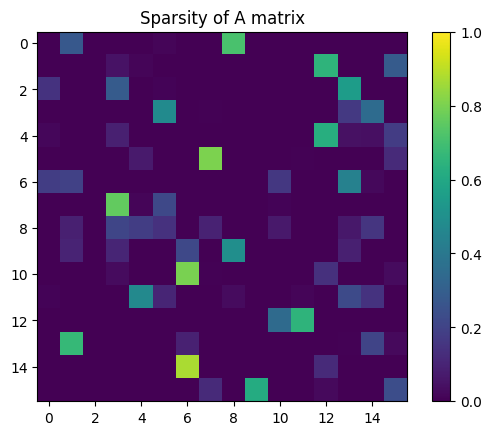

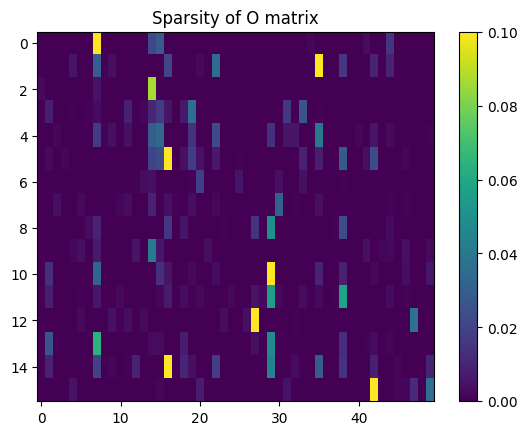

In [ ]:
visualize_sparsities(HMM, O_max_cols=50)

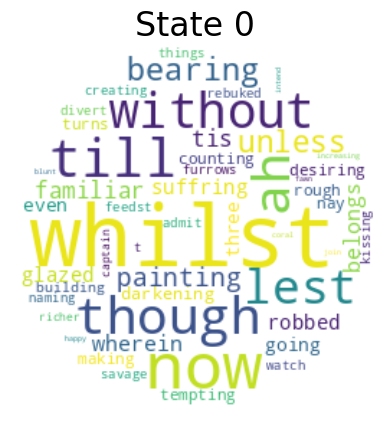

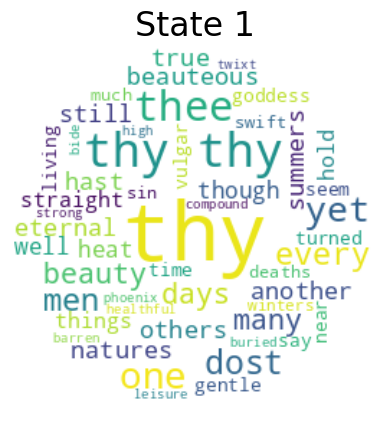

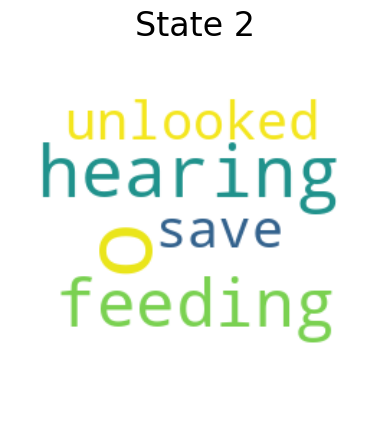

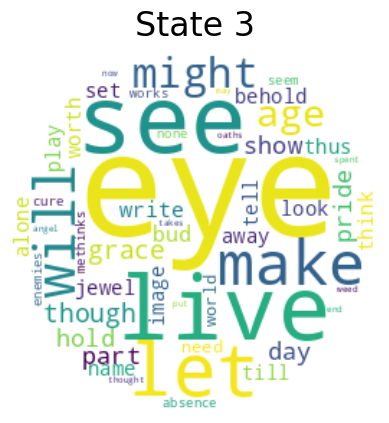

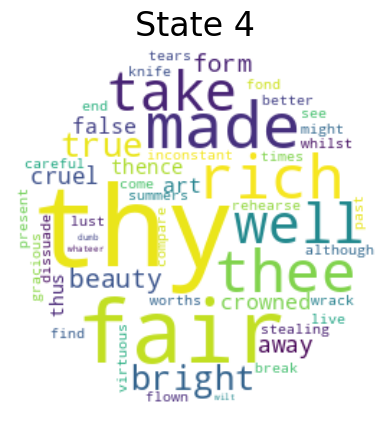

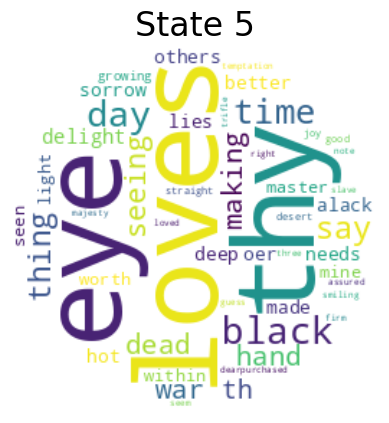

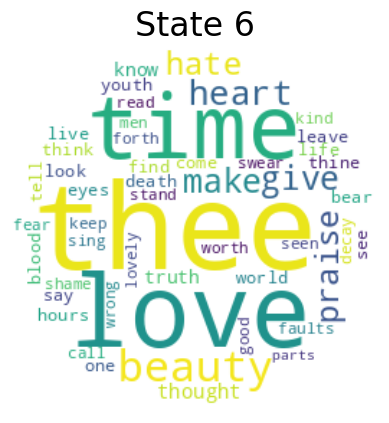

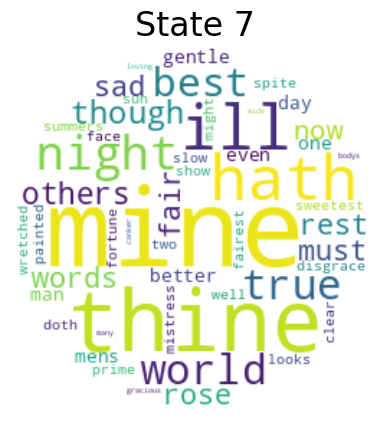

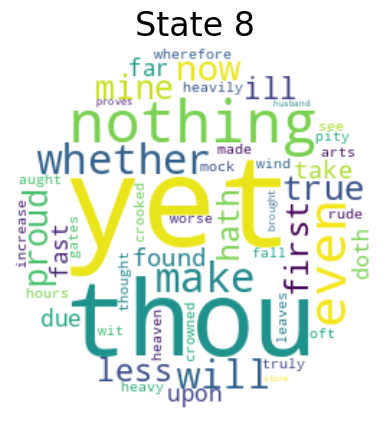

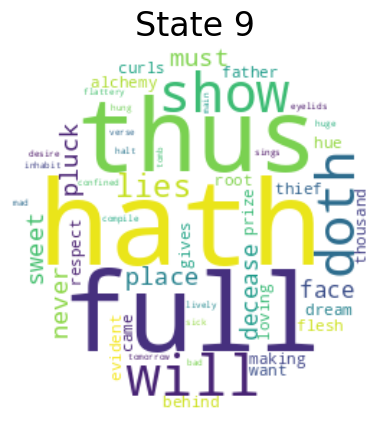

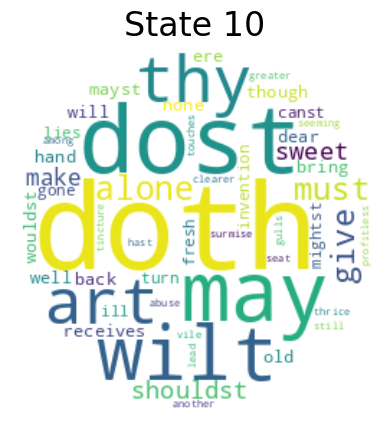

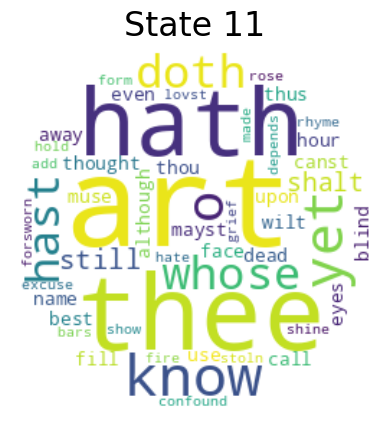

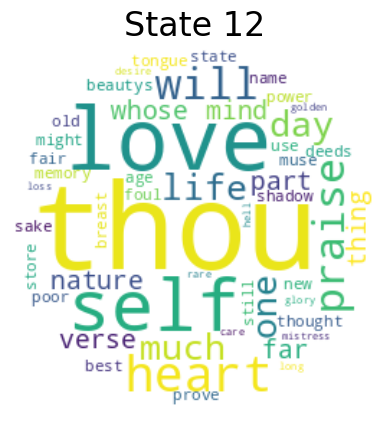

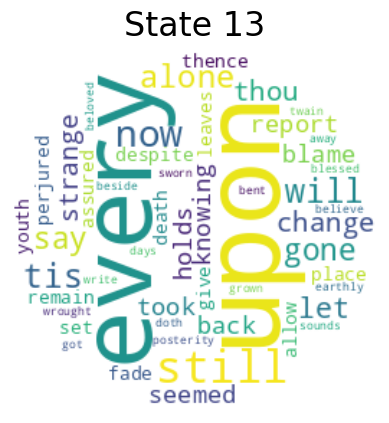

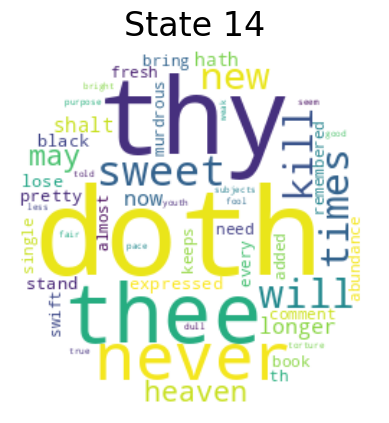

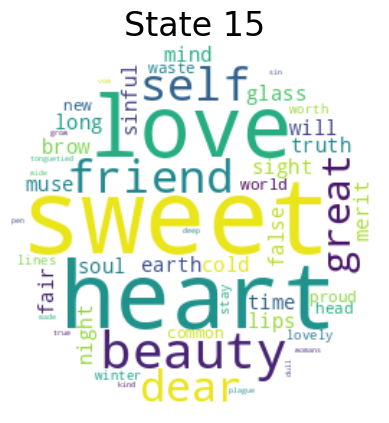

In [ ]:
wordclouds = states_to_wordclouds(HMM, obs_map)

In [ ]:
# print top 10 words for all 16 hidden states
obs_map_r = obs_map_reverser(obs_map)
print("Top 10 words for different hidden states")
for i in range(HMM.L):
    observations = HMM.O[i]
    top_indices = np.argsort(observations)[-10:]
    print(f"hidden state {i}:", end=' ')
    for index in top_indices:
        print(obs_map_r[index], end=' ')
    print()

Top 10 words for different hidden states
hidden state 0: but as nor for if how or when that and 
hidden state 1: with her i the that so his your thy my 
hidden state 2: than for or when yet then so which but o 
hidden state 3: see own as have eyes is eye by of in 
hidden state 4: be fair his so but as it not thy my 
hidden state 5: no and as a their with my of in the 
hidden state 6: do all beauty you time not be love me thee 
hidden state 7: some have hath an true can they do thine mine 
hidden state 8: can he for then yet with you all to i 
hidden state 9: hath would since then or nor for but which and 
hidden state 10: dost shall be for are doth that i of to 
hidden state 11: be being hath up me thee art to with is 
hidden state 12: who had will praise heart am it self love thou 
hidden state 13: be what not from for on to that in of 
hidden state 14: his that your my thy doth me to i the 
hidden state 15: loves love friend dear heart most beauty this sweet a 
